# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a *Jupyter notebook* for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

#### Import necessary packages
You may import more packages here.

In [1]:
# Import necessary packages here
import re
from os.path import join
import numpy as np

In [2]:
# Define test sets
dataDir = '../semeval-tweets'
testsetStrings = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']
testsets = [join(dataDir, t) for t in testsetStrings]
print(testsets)

['../semeval-tweets/twitter-test1.txt', '../semeval-tweets/twitter-test2.txt', '../semeval-tweets/twitter-test3.txt']


In [3]:
# checking the structure of the dataset
with open(testsets[0], 'r', encoding='utf8') as f1:
    i = 0
    for line in f1:
        fields = line.split('\t')
        if i < 30:
            length = len(fields[2])
            if length > 130:
                print(f"Lenght: {length}")
                print(fields[0])  # 1st column - tweet ID
                print(fields[1])  # 2nd column - tweet sentiment
                print(fields[2])  # 3rd column - tweet text
                i += 1

# preprocessing questions and notes: 
  # -> what about removing the @usernames, is it advisable?
  # -> need to remove URLs!
  # -> There is a lot of noise/mistakes in the data and absence of interpunction.
  # -> what about adding of the starting token?  

Lenght: 139
102313285628711403
neutral
"Bing one-ups knowledge graph, hires Encyclopaedia Britannica to supply results:   It may have retired from the cut-throat world of pr..."

Lenght: 139
653274888624828198
neutral
"On Thursday, concealed-carry gun license holders will be given a new right in the state of Oklahoma: the ability... http://t.co/oSgGHKi1"

Lenght: 137
420747042670198316
negative
Miyagi just got banned from yoga. He was caught him sniffing the sphincter of the girl in front of him. There may be police involvement!

Lenght: 135
822064800445716046
neutral
Join us tonight at Boston Pizza - Centre on Barton for THURSDAY NIGHT FOOTBALL! Tonight the Chiefs take on the... http://t.co/iegTxPQv

Lenght: 139
055480020953212084
neutral
"#FX NEW YORK, Oct 18 (Reuters) - The Federal Reserve provided $4.701 billion of liquidity to the ... http://t.co/BJhIQTtO #EUR #AUD #CAD"

Lenght: 132
429443270273347255
neutral
"13 April 1996, History is made, as the MetroStars and the Los Angeles 

In [4]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    reading the testset and return a dictionary with: ID -> sentiment
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}  # init the dictionary
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]
            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1
        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1
        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1
        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)
    return semevalmacrof1

In [5]:
# testing the evaluation functions
tweetDict = read_test('../semeval-tweets/twitter-test1.txt')
confusion(tweetDict, '../semeval-tweets/twitter-test1.txt', "PerfectClassifier")
evaluate(tweetDict, '../semeval-tweets/twitter-test1.txt', "PerfectClassifier")

            positive  negative  neutral
positive    1.000     0.000     0.000     
negative    0.000     1.000     0.000     
neutral     0.000     0.000     1.000     

../semeval-tweets/twitter-test1.txt (PerfectClassifier): 1.000


1.0

---
## Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [26]:
# Load training set, dev set and testing set

dataDir = '../semeval-tweets'  # change to the proper directory
datasetStrings = ['twitter-training-data.txt', 'twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt', 'twitter-dev-data.txt']
datasets = [join(dataDir, t) for t in datasetStrings]

tweet_IDs = {}          # init dictionary with tweet IDs
tweet_sentiments = {}   # init dictionary with sentiments
tweet_texts = {}        # init dictionary with tweet texts

for DatasetString in datasets:
    data_ID, data_sent, data_text  = {}, {}, {}    # temp dictionaries
    with open(DatasetString, 'r', encoding='utf8') as f1:
        for i, line in enumerate(f1):
            fields = line.split('\t')
            data_ID[i] = fields[0]            # tweet IDs
            data_sent[fields[0]] = fields[1]  # sentiments
            data_text[fields[0]] = fields[2]  # tweet text
    tweet_IDs[DatasetString] = data_ID
    tweet_sentiments[DatasetString] = data_sent
    tweet_texts[DatasetString] = data_text

# sentiment dictionaries
sent_train = tweet_sentiments[datasets[0]]
sent_test1 = tweet_sentiments[datasets[1]]
sent_test2 = tweet_sentiments[datasets[2]]
sent_test3 = tweet_sentiments[datasets[3]]
sent_dev = tweet_sentiments[datasets[4]]

# tweet text dictionaries
text_train = tweet_texts[datasets[0]]
text_test1 = tweet_texts[datasets[1]]
text_test2 = tweet_texts[datasets[2]]
text_test3 = tweet_texts[datasets[3]]
text_dev = tweet_texts[datasets[4]]

# tweet IDs dictionaries
IDs_train = tweet_IDs[datasets[0]]
IDs_test1 = tweet_IDs[datasets[1]]
IDs_test2 = tweet_IDs[datasets[2]]
IDs_test3 = tweet_IDs[datasets[3]]
IDs_dev = tweet_IDs[datasets[4]]


## examples and tests
# id = IDs_train[0]
# id_dev = IDs_dev[0]
# id1 = IDs_test1[0]
# id2 = IDs_test2[0]
# id3 = IDs_test3[0]
# print(f"-ID:{id} \n-TEXT:{text_train[id]}-SENTIMENT: {sent_train[id]}\n")
# print(f"-ID:{id_dev} \n-TEXT:{text_dev[id_dev]}-SENTIMENT: {sent_dev[id_dev]}\n")
# print(f"-ID:{id1} \n-TEXT:{text_test1[id1]}-SENTIMENT: {sent_test1[id1]}\n")
# print(f"-ID:{id2} \n-TEXT:{text_test2[id2]}-SENTIMENT: {sent_test2[id2]}\n")
# print(f"-ID:{id3} \n-TEXT:{text_test3[id3]}-SENTIMENT: {sent_test3[id3]}\n")
# print(len(IDs_train.keys()), len(text_train.keys()), len(sent_train.keys()))  # 45101
# print(len(IDs_test1.keys()), len(text_test1.keys()), len(sent_test1.keys()))  # 3531
# print(len(IDs_test2.keys()), len(text_test2.keys()), len(sent_test2.keys()))  # 1853
# print(len(IDs_test3.keys()), len(text_test3.keys()), len(sent_test3.keys()))  # 2379
# print(len(IDs_dev.keys()), len(text_dev.keys()), len(sent_dev.keys()))        # 2000

---
#### Order of preprocessing
* lowercase text
* regex cleaning
   * Remove URLs
   * Remove non-alphanumeric characters (leave hashtags and usernames)
   * Remove numbers that are fully made of digits
   * (Remove words with only 1 character)

 #### Preprocessing questions and notes:
   -> what about removing the @usernames, is it advisable?
   -> need to remove URLs!
   -> There is a lot of noise/mistakes in the data and absence of interpunction.
   -> what about adding of the starting token?

In [27]:
import os
import re
import pickle
import nltk
from nltk.stem import WordNetLemmatizer

# loading preprocessed datasets
#file_to_load = "preprocessing-plain.pkl"  # "preprocessing-glove.pkl"
file_to_load = "preprocessing-glove.pkl"
if os.path.isfile(file_to_load):
    with open(file_to_load, 'rb') as inp_file:
        temp_dicts = pickle.load(inp_file)
        txt_dicts = temp_dicts[0:5]
        txtlist_dicts = temp_dicts[5:]

else:
    top100 = ['com', 'net', 'org', 'jp', 'de', 'uk', 'fr', 'br', 'it', 'ru', 'es', 'me', 'gov', 'pl', 'ca', 'au', 'cn', 'co', 'in', 'nl', 'edu', 'info', 'eu', 'ch', 'id', 'at', 'kr', 'cz', 'mx', 'be', 'tv', 'se', 'tr', 'tw', 'al', 'ua', 'ir', 'vn', 'cl', 'sk', 'ly', 'cc', 'to', 'no', 'fi', 'us', 'pt', 'dk', 'ar', 'hu', 'tk', 'gr', 'il', 'news', 'ro', 'my', 'biz', 'ie', 'za', 'nz', 'sg', 'ee', 'th', 'io', 'xyz', 'pe', 'bg', 'hk', 'rs', 'lt', 'link', 'ph', 'club', 'si', 'site', 'mobi', 'by', 'cat', 'wiki', 'la', 'ga', 'xxx', 'cf', 'hr', 'ng', 'jobs', 'online', 'kz', 'ug', 'gq', 'ae', 'is', 'lv', 'pro', 'fm', 'tips', 'ms', 'sa', 'app', 'lat']

    glove_emoticons = [';)', '=)', ':]', ':3', ':(', ':-)', '0:3', ':@', ':)', ':|', '=p']
    glove_emoticon_strings = ['emoticon' + str(num) for num in range(len(emoticons))]
    emoticon2string = dict(zip(glove_emoticons, glove_emoticon_strings))
    string2emoticon = dict(zip(glove_emoticon_strings, glove_emoticons))

    ID_dicts = [IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev]
    txt_dicts = [text_train, text_test1, text_test2, text_test3, text_dev]
    txtlist_dicts = []

    lemmatizer = WordNetLemmatizer()  # init the lemmatizer
    POSconvert = lambda e: ('a' if e[0].lower() == 'j' else e[0].lower()) if e[0].lower() in ['n', 'r', 'v'] else 'n'

    for i, IDdict in enumerate(ID_dicts):
        output = txt_dicts[i]
        output_txt = {}
        for id in IDdict.values():
            text = output[id].lower()

            # replace/delete all URLs starting with 'http' and 'www'
            new_text = re.sub("http[^\s]*", '', text)
            new_text = re.sub("www[^\s]*", '', new_text)

            # delete all URLs which have one of 100 most common extensions ('.com', '.net', ...)
            for ext in top100:
                re_string = "[^\s]*\." + ext + "[^\s]*"
                new_text = re.sub(re_string, '', new_text)

            #replace all emoticons with an emoticon string:  #emoticon42
            for em in glove_emoticons:
                re_string = '\s' + re.escape(em) + '\s'
                replace_string = ' ' + emoticon2string[em] + ' '
                new_text = re.sub(re_string, replace_string, new_text)

            # removing '&amp'
            new_text = re.sub('&amp','', new_text)

            # remove all non-alphanumeric chars except for '# and @'
            new_text = re.sub('[^\w\s@#]','', new_text)

            # replace all @usernames with 'username'
            new_text = re.sub('\s@[^\s]+',' username', new_text)  # middle
            new_text = re.sub('^@[^\s]+','username', new_text)    # start

            # remove strings with '#' not on the beginning (to keep only hashtags)
            new_text = re.sub('\s[\w]+#[\w]*','', new_text)

            # replace #hashtags with 'hashtag' and '#hashtag1 #hashtag2' with 'hashtags'
            new_text = re.sub('#[^\s]*\s',' hashtag ', new_text)
            new_text = re.sub('\s#[^\s]*$',' hashtag ', new_text)
            new_text = re.sub('(\s+hashtag){2,}', ' hashtags', new_text)

            # remove all non-alphanumeric chars
            new_text = re.sub('[^\w\s]','', new_text)

            # numbers fully made of digits
            new_text = re.sub('\s[\d]+\s','', new_text)

            # remove words with only 1 character
            new_text = re.sub('\\b\\w{1}\\b','', new_text)

            # remove newline chars
            new_text = new_text.replace('\n', ' ')

            # replace a multiple spaces with a single space
            new_text = re.sub('\s+',' ', new_text)

            # using the lemmatizer
            txt_list = nltk.word_tokenize(new_text)
            for k, word in enumerate(txt_list):  # fixing the separation of hashtags by the tokenizer
                if word == '#' or word == '@':
                    if k < len(txt_list) - 1:
                        txt_list[k] = txt_list[k] + txt_list[k+1]
                        txt_list.pop(k+1)
            POS = nltk.pos_tag(txt_list)                  # POS tags from nltk
            WordNetPOS = [POSconvert(P[1]) for P in POS]  # POS tags for lemmatizer
            for j in range(len(txt_list)):
                word = txt_list[j]
                lemmatized = lemmatizer.lemmatize(word, WordNetPOS[j])  # process each token/word one by one
                if lemmatized in glove_emoticon_strings:
                    lemmatized = string2emoticon[lemmatized]
                txt_list[j] = lemmatized  # update the word in the txt_list

            ## UPDATE the dictionary
            output_txt[id] = ' '.join(txt_list)
            output[id] = txt_list

        txt_dicts[i] = output_txt
        txtlist_dicts.append(output)

text_train = txt_dicts[0]
text_test1 = txt_dicts[1]
text_test2 = txt_dicts[2]
text_test3 = txt_dicts[3]
text_dev = txt_dicts[4]
txtlist_train = txtlist_dicts[0]
txtlist_test1 = txtlist_dicts[1]
txtlist_test2 = txtlist_dicts[2]
txtlist_test3 = txtlist_dicts[3]
txtlist_dev = txtlist_dicts[4]

# saving preprocessing.pkl
file_to_save = "preprocessing" + file_to_load[13:]
if not os.path.isfile(file_to_save):
    txt_dicts = [text_train, text_test1, text_test2, text_test3, text_dev, txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev]
    with open(file_to_save, 'wb') as out_file:
        pickle.dump(txt_dicts, out_file, protocol=-1)

In [8]:
# checking the preprocessed output
for id in list(IDs_train.values())[200:300]:
    print(text_train[id])

rip frank gifford monday night football have never be the same without you #turnoutthelightsthepartysover
today the last two wisconsin recall for now keep up the extraordinary work wisconsin
@goldberg do you agree with me that spear christian be your 2nd best spear after to that guy you do spear to in royal rumble
trump aim his sharpest tweet at jeb bush but with ben carson surge in 2nd place be trump miss the target @saramurray have more
#putin have have it with #obama and have decide to throw #america out of #syria negotiation
remember stand on suncorpmins b4 1st lion test @seanny202 say this be rugby match it mate #marlinswallabies
the government need to start listening and stop do damage to uk higher education with negative massage on immi
@nidge1uk yer off to take son for his first day at big school then it google analytics train for me how be your night
my bad let me fixate yall may be muslim but youre not practice muslim
use of htc vive virtual realitymy experience with google e

---
## Feature Extraction: Bag of words

In [29]:
# Bag of Words - my implementation:
from nltk.probability import FreqDist
from nltk.corpus import stopwords as Stopwords
from scipy.sparse import csr_matrix

# loading preprocessed datasets
#file_to_load = "BOWsparse-plain.pkl"  # "BOWsparse-glove.pkl"
file_to_load =  "BOWsparse-glove.pkl"
if os.path.isfile(file_to_load):
    with open(file_to_load, 'rb') as inp_file:
        temp = pickle.load(inp_file)
        [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev] = temp
else:
    # 1) removing stop words
    stopwords = Stopwords.words('english')
    stopwords = [word.replace('\'', '') for word in stopwords]

    # 2) extracting the dictionary/vocabulary
    freq = FreqDist()   # frequency distribution
    for Dict in txtlist_dicts:
        for tweet in Dict.values():
            for word in tweet:
                if not word in stopwords:
                    freq[word] += 1

    nums = range(1, len(freq.keys())+1)
    vocabulary = list(freq.keys())              # creating the dictionary
    vocabularyOOV = vocabulary + ['<OOV>']      # dictionary with 'out of vocabulary' word
    vocab2num = dict(zip(vocabulary, nums))     # word to index mapping
    vocab2num['<OOV>'] = max(vocab2num.values()) + 1  # out of vocabulary words -> len: 69742

    # auxiliary ftion which takes list of words and returns its BoW representation as np.array
    def text2BOW(text_list, vocabulary, stopwords):
        BOW_vec = np.zeros(len(vocabulary) + 1)
        for word in text_list:
            if not word in stopwords:
                if word in vocabulary:
                    BOW_vec[vocab2num[word]] += 1
                else:
                    BOW_vec[vocab2num['<OOV>']] += 1
        return BOW_vec

    # if os.path.isfile("BOWs.pkl"):  # loading preprocessed datasets
    #     with open('BOWs.pkl', 'rb') as inp_file:
    #         ll = pickle.load(inp_file)
    #         BOW_train, BOW_test1, BOW_test2, BOW_test3, BOW_dev = ll[0], ll[1], ll[2], ll[3], ll[4]
    #
    # else:
    # Bag of Words (BOW) for each tweet
    BOW_train = {}
    for ID, tweet in txtlist_train.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords)
        BOW_train[ID] = BOW

    BOW_test1 = {}
    for ID, tweet in txtlist_test1.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords)
        BOW_test1[ID] = BOW

    BOW_test2 = {}
    for ID, tweet in txtlist_test2.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords)
        BOW_test2[ID] = BOW

    BOW_test3 = {}
    for ID, tweet in txtlist_test3.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords)
        BOW_test3[ID] = BOW

    BOW_dev = {}
    for ID, tweet in txtlist_dev.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords)
        BOW_dev[ID] = BOW


    # saving BOWs.pkl: very large file - maybe not the best idea to save it?
        # if not os.path.isfile("BOWs.pkl"):
        #     BOW_dicts = [BOW_train, BOW_test1, BOW_test2, BOW_test3, BOW_dev]
        #     with open("BOWs.pkl", 'wb') as out_file:
        #         pickle.dump(BOW_dicts, out_file, protocol=-1)

    print("Starting sparse processing.")

    # sparse representation
    vector_list = [BOW_train[id] for id in BOW_train.keys()]
    dense_train = np.vstack(vector_list)    # shape (45101, 59559)
    sparse_train = csr_matrix(dense_train)  # getting the sparse matrix

    vector_list = [BOW_test1[id] for id in BOW_test1.keys()]
    dense_test1 = np.vstack(vector_list)    # shape (3531, 59559)
    sparse_test1 = csr_matrix(dense_test1)  # getting the sparse matrix

    vector_list = [BOW_test2[id] for id in BOW_test2.keys()]
    dense_test2 = np.vstack(vector_list)    # shape (1853, 59559)
    sparse_test2 = csr_matrix(dense_test2)  # getting the sparse matrix

    vector_list = [BOW_test3[id] for id in BOW_test3.keys()]
    dense_test3 = np.vstack(vector_list)    # shape (2379, 59559)
    sparse_test3 = csr_matrix(dense_test3)  # getting the sparse matrix

    vector_list = [BOW_dev[id] for id in BOW_dev.keys()]
    dense_dev = np.vstack(vector_list)      # shape (2000, 59559)
    sparse_dev = csr_matrix(dense_dev)      # getting the sparse matrix

    # train + dev together (combined)
    vector_list1 = [BOW_train[id] for id in BOW_train.keys()]
    vector_list2 = [BOW_dev[id] for id in BOW_dev.keys()]
    temp1 = np.vstack(vector_list1)
    temp2 = np.vstack(vector_list2)
    dense_train_dev = np.vstack((temp1, temp2))  # shape (45101, 59559)
    sparse_train_dev = csr_matrix(dense_train_dev)  # getting the sparse matrix


# save the sparse representation
file_to_save = "BOWsparse" + file_to_load[9:]
if not os.path.isfile(file_to_save):
    sparse_dicts = [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev]
    with open(file_to_save, 'wb') as out_file:
        pickle.dump(sparse_dicts, out_file, protocol=-1)


In [ ]:
with open("BOWsparse-plain.pkl", 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev] = temp

---
## Feature Extraction: TF-IDF weighted Bag of words

In [ ]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords as Stopwords
from scipy.sparse import csr_matrix

# stop words
stopwords = Stopwords.words('english')
stopwords = [word.replace('\'', '') for word in stopwords]

# extracting the dictionary
freq = FreqDist()   # frequency distribution
for Dict in txtlist_dicts:
    for tweet in Dict.values():
        for word in tweet:
            if not word in stopwords:
                freq[word] += 1

nums = range(1,len(freq.keys())+1)
vocabulary = list(freq.keys())              # creating the dictionary
vocabulary_array = np.array(vocabulary)     # np.array of the dictionary
vocabularyOOV = vocabulary + ['<OOV>']      # dictionary with 'out of vocabulary' word
vocab2num = dict(zip(vocabulary, nums))     # word to index mapping
vocab2num['<OOV>'] = max(vocab2num.values()) + 1  # out of vocabulary words -> len: 69742

# extracting the dictionary
DFfreq = FreqDist()   # document frequency distribution
Ntexts = len(IDs_train) + len(IDs_test1) + len(IDs_test2) + len(IDs_test3) + len(IDs_dev)
for Dict in txtlist_dicts:
    for tweet in Dict.values():
        for word in np.unique(tweet):
            if not word in stopwords:
                DFfreq[word] += 1

# auxiliary ftion which takes list of words and returns its TFIDF representation as np.array
def text2TFIDF(text_list, vocabulary, stopwords, Ntexts):
    TFIDF_vec = np.zeros(len(vocabulary) + 1)
    for word in np.unique(text_list):
        if not word in stopwords:
            if word in vocabulary:
                tf = np.count_nonzero(np.array(text_list) == word) / len(text_list)
                idf = np.log2(Ntexts / DFfreq[word])
                TFIDF_vec[vocab2num[word]] = tf * idf
            else:
                tf = np.count_nonzero(np.array(text_list) == word) / len(text_list)
                idf = np.log2(Ntexts / 0.000001 )
                TFIDF_vec[vocab2num['<OOV>']] = tf * idf
    return TFIDF_vec


# TFIDF-weighted Bag of Words for each tweet
TFIDF_train = {}
for ID, tweet in txtlist_train.items():
    tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, Ntexts=Ntexts)
    TFIDF_train[ID] = tfidf

TFIDF_test1 = {}
for ID, tweet in txtlist_test1.items():
    tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, Ntexts=Ntexts)
    TFIDF_test1[ID] = tfidf

TFIDF_test2 = {}
for ID, tweet in txtlist_test2.items():
    tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, Ntexts=Ntexts)
    TFIDF_test2[ID] = tfidf

TFIDF_test3 = {}
for ID, tweet in txtlist_test3.items():
    tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, Ntexts=Ntexts)
    TFIDF_test3[ID] = tfidf

TFIDF_dev = {}
for ID, tweet in txtlist_dev.items():
    tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, Ntexts=Ntexts)
    TFIDF_dev[ID] = tfidf

print("Starting sparse processing.")

# sparse TFIDF representation
vector_list = [TFIDF_train[id] for id in TFIDF_train.keys()]
TFIDFdense_train = np.vstack(vector_list)
TFIDFsparse_train = csr_matrix(TFIDFdense_train)  # getting the sparse matrix

vector_list = [TFIDF_test1[id] for id in TFIDF_test1.keys()]
TFIDFdense_test1 = np.vstack(vector_list)
TFIDFsparse_test1 = csr_matrix(TFIDFdense_test1)  # getting the sparse matrix

vector_list = [TFIDF_test2[id] for id in TFIDF_test2.keys()]
TFIDFdense_test2 = np.vstack(vector_list)
TFIDFsparse_test2 = csr_matrix(TFIDFdense_test2)  # getting the sparse matrix

vector_list = [TFIDF_test3[id] for id in TFIDF_test3.keys()]
TFIDFdense_test3 = np.vstack(vector_list)
TFIDFsparse_test3 = csr_matrix(TFIDFdense_test3)  # getting the sparse matrix

vector_list = [TFIDF_dev[id] for id in TFIDF_dev.keys()]
TFIDFdense_dev = np.vstack(vector_list)
TFIDFsparse_dev = csr_matrix(TFIDFdense_dev)  # getting the sparse matrix

vector_list1 = [TFIDF_train[id] for id in TFIDF_train.keys()]
vector_list2 = [TFIDF_dev[id] for id in TFIDF_dev.keys()]
temp1 = np.vstack(vector_list1)
temp2 = np.vstack(vector_list2)
TFIDFdense_train_dev = np.vstack((temp1, temp2))  # shape (45101, 59559)
TFIDFsparse_train_dev = csr_matrix(TFIDFdense_train_dev)  # getting the sparse matrix

# save the sparse representation
sparse_dicts = [TFIDFsparse_train, TFIDFsparse_test1, TFIDFsparse_test2, TFIDFsparse_test3, TFIDFsparse_dev, TFIDFsparse_train_dev]
with open("TFIDFsparse-plain.pkl", 'wb') as out_file:
    pickle.dump(sparse_dicts, out_file, protocol=-1)

## loading preprocessed TFIDF sparse data
# with open("TFIDFsparse.pkl", 'rb') as inp_file:
#     temp = pickle.load(inp_file)
#     [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev] = temp

In [15]:
# loading preprocessed TFIDF sparse data
with open("TFIDFsparse.pkl", 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev] = temp
#[BOW_train, BOW_test1,BOW_test2,BOW_test3,BOW_dev] = [TFIDF_train, TFIDF_test1,TFIDF_test2,TFIDF_test3,TFIDF_dev]

---
## Feature Extraction: GloVe

In [ ]:
tups = {'word1': 100,'word2': 5,'word3': 13 }
#print(sorted(tups, key=lambda data: data[1], reverse=True))

Sorted = sorted([it for it in tups.items()], key=lambda data: data[1], reverse=True)
print([ tup[0] for tup in Sorted ])
print([ tup[1] for tup in Sorted ])

In [19]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords as Stopwords
# Loading the word embeddings vectors from GloVE

print('Extracting the word vectors.')

txtlist_dicts = [txtlist_train, txtlist_dev]

# 1) removing stop words
stopwords = Stopwords.words('english')
stopwords = [word.replace('\'', '') for word in stopwords]

# 2) extracting the dictionary/vocabulary
freq = FreqDist()   # frequency distribution
for Dict in txtlist_dicts:
    for tweet in Dict.values():
        for word in tweet:
            if not word in stopwords:
                freq[word] += 1

full_embedding_dict = {}
glove_path = join('..','glove', 'glove.6B.100d.txt')
with open(glove_path, 'r', encoding='utf-8') as File:
    for line in File:
        vec = line.split()
        word = vec[0]
        coefs = np.asarray(vec[1:], dtype='float32')
        full_embedding_dict[word] = coefs

print(f"Extracted {len(full_embedding_dict)} word embedding vectors.")

sorted_vocabulary = sorted([it for it in freq.items()], key=lambda data: data[1], reverse=True)
full_vocabulary = [ tup[0] for tup in sorted_vocabulary ]

embedding_dict = {}  # word embeddings of 6000 words from vocabulary
temp = 0
for word in full_vocabulary:
    if word in full_embedding_dict.keys():
        embedding_dict[word] = full_embedding_dict[word]
        temp += 1
    if temp == 4998:
        break
vocabulary = list(embedding_dict.keys())  # obtain the dictionary of 6000 most common words

print(f"Created dictionary of {len(embedding_dict)} most common words.")

# extract the <OOV> vector by setting it to be the weighted avg of unused words
Total = np.zeros(100)
Sum = 0
for word in full_vocabulary:
    if word not in vocabulary:                              # if word is not among 6000 words
        if word in full_embedding_dict.keys():              # and it is in glove
            Total += freq[word] * full_embedding_dict[word] # take the weighted avg
            Sum += freq[word]
OOV_vector = Total / Sum
embedding_dict['<OOV>'] = OOV_vector

print(f"The embedding dictionary has {len(embedding_dict)} words, the last one is: {list(embedding_dict.keys())[-1]}")

# Build an embedding matrix
word_list = list(embedding_dict.keys())
nums = range(1,len(word_list)+1)
word2ID = dict(zip(word_list, nums))   # the index of the embedding vector
vector_list = [embedding_dict[word] for word in word_list]

embedding_matrix = np.vstack(vector_list)
embedding_matrix = np.vstack((np.zeros(100), embedding_matrix))

print(f"Created matrix with shape {embedding_matrix.shape}")  # the first row is a dummy row

# save the embeddings
with open("embeddings.pkl", 'wb') as out_file:
    temp = [embedding_matrix, word2ID, embedding_dict]
    pickle.dump(temp, out_file, protocol=-1)

## loading preprocessed embeddings (embedding matrix, word to index map, embedding dictionary)
# with open("embeddings.pkl", 'rb') as inp_file:
#     temp = pickle.load(inp_file)
#     [embedding_matrix, word2ID, embedding_dict] = temp

Extracting the word vectors.
Extracted 400000 word embedding vectors.
Created dictionary of 4998 most common words.
The embedding dictionary has 4999 words, the last one is: <OOV>
Created matrix with shape (5000, 100)


---
## Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over all 5 test sets (2 of them are not provided to you).

### Nearest Neighbour Classifier

In [ ]:
# grid search for KNN classifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

params = {'n_neighbors': list(range(1,15)),
          'metric': ['l1', 'l2', 'cosine'],
          'weights': ['uniform', 'distance']}

grid_clf = GridSearchCV(
    estimator = KNeighborsClassifier(),
    scoring = 'f1_macro',   # accuracy, balanced_accuracy, f1, roc_auc, average_precision (=pr_auc)
    cv = 3,
    param_grid = params)

grid_clf.fit(Xtrain, Ytrain_numeric)
print('Best params: ', grid_clf.best_params_)
print(grid_clf.best_estimator_)
print(classification_report(y_test1_numeric, grid_clf.predict(sparse_test1)))
scores = abs(grid_clf.cv_results_['mean_test_score'])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import time

def sent2num(sent):
    if sent == 'negative':
        return -1
    if sent == 'neutral':
        return 0
    if sent == 'positive':
        return 1

def num2sent(num):
    if num == -1:
        return 'negative'
    if num == 0:
        return 'neutral'
    if num == 1:
        return 'positive'

# BOW_train, BOW_dev -> non-sparse implementation
# IDtrain = list(BOW_train.keys())            # list of IDs in train set
# IDdev = list(BOW_dev.keys())                # list of IDs in development (validation) set
# Xtrain = np.array([BOW_train[id] for id in IDtrain])     # training set
# Ytrain = np.array([sent_train[id] for id in IDtrain])    # training labels
# Ytrain_numeric = np.array([sent2num(y) for y in Ytrain]) # numerical labels
# Xdev = np.array([BOW_dev[id] for id in IDdev])  # development set
# Ydev = np.array([sent_dev[id] for id in IDdev]) # training labels
# Ydev_numeric = np.array([sent2num(y) for y in Ydev])

# sparse implementation
Xtrain = sparse_train_dev  # combining the two datasets
print("shape", Xtrain.shape)###
ID_train = list(BOW_train.keys())            # list of IDs in train set
ID_dev = list(BOW_dev.keys())
ID_train_dev = ID_train + ID_dev
sn_train = [sent_train[id] for id in ID_train]  # training labels train
sn_dev = [sent_dev[id] for id in ID_dev]        # training labels dev
Ytrain = np.array(sn_train)            # combining both labels
Ytrain = np.array(sn_train + sn_dev)###            # combining both labels
Ytrain_numeric = np.array([sent2num(y) for y in Ytrain])   # numerical labels

t0 = time.time() # timing the run
clf = KNeighborsClassifier(n_neighbors=9, metric='cosine', weights='uniform')
clf.fit(Xtrain, Ytrain_numeric)
# y_scores = clf.predict_proba(Xdev)[:,1]


# evaluation test1
ID_test1 = list(BOW_test1.keys())
y_test1_numeric = np.array([sent2num(sent) for sent in sent_test1.values()])
y_pred_numeric = clf.predict(sparse_test1)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test1, y_pred))
s1 = evaluate(pred_dict, '../semeval-tweets/twitter-test1.txt', classifier="KNN")  # best score 0.435

# evaluation test2
ID_test2 = list(BOW_test2.keys())
y_test2_numeric = np.array([sent2num(sent) for sent in sent_test2.values()])
y_pred_numeric = clf.predict(sparse_test2)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test2, y_pred))
s2 = evaluate(pred_dict, '../semeval-tweets/twitter-test2.txt', classifier="KNN")  # best score 0.435

# evaluation test3
ID_test3 = list(BOW_test3.keys())
y_test3_numeric = np.array([sent2num(sent) for sent in sent_test3.values()])
y_pred_numeric = clf.predict(sparse_test3)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test3, y_pred))
s3 = evaluate(pred_dict, '../semeval-tweets/twitter-test3.txt', classifier="KNN")  # best score 0.435
t1 = time.time()  # timing the run
print('overall run time:', t1-t0)
print("average F1 score:", (s1 + s2 + s3)/3)


# other performance metrics
#accuracy = np.mean(y_pred_numeric == y_test1_numeric)
#confusion(pred_dict, '../semeval-tweets/twitter-test1.txt', classifier="KNN")


# conf = confusion_matrix(y_test1_numeric, y_pred_numeric)
# print('  -1   0   1')
# print(conf)

### Naive Bayes Classifier

In [16]:
# Multinomial NaiveBayes: finding the best params using GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

params = {'alpha': np.logspace(2,-7, num=50)}

grid_clf = GridSearchCV(
    estimator = MultinomialNB(),
    scoring = 'f1_macro',
    cv = 3,
    param_grid = params)

grid_clf.fit(Xtrain, Ytrain_numeric)
print('Best params: ', grid_clf.best_params_)
print(grid_clf.best_estimator_)
print(classification_report(y_test1_numeric, grid_clf.predict(sparse_test1)))
scores = abs(grid_clf.cv_results_['mean_test_score'])

# Best params:  {'alpha': 0.4094915062380423} -> macro avg f1  0.52

Best params:  {'alpha': 0.4094915062380423}
MultinomialNB(alpha=0.4094915062380423)
              precision    recall  f1-score   support

          -1       0.51      0.37      0.43       557
           0       0.58      0.52      0.55      1504
           1       0.58      0.70      0.64      1470

    accuracy                           0.57      3531
   macro avg       0.56      0.53      0.54      3531
weighted avg       0.57      0.57      0.57      3531



In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import time

Xtrain = sparse_train_dev  # combining the two datasets
print("shape", Xtrain.shape)###
ID_train = list(BOW_train.keys())            # list of IDs in train set
ID_dev = list(BOW_dev.keys())
ID_train_dev = ID_train + ID_dev
sn_train = [sent_train[id] for id in ID_train]  # training labels train
sn_dev = [sent_dev[id] for id in ID_dev]        # training labels dev
Ytrain = np.array(sn_train)            # combining both labels
Ytrain = np.array(sn_train + sn_dev)###            # combining both labels
Ytrain_numeric = np.array([sent2num(y) for y in Ytrain])   # numerical labels

t0 = time.time() # timing the run
clf = MultinomialNB(alpha = 0.4)
clf.fit(Xtrain,Ytrain_numeric)
#y_scores = clf.predict_proba(Xv)[:,1]

# evaluation test1
ID_test1 = list(BOW_test1.keys())
y_test1_numeric = np.array([sent2num(sent) for sent in sent_test1.values()])
y_pred_numeric = clf.predict(sparse_test1)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test1, y_pred))
s1 = evaluate(pred_dict, '../semeval-tweets/twitter-test1.txt', classifier="KNN")  # best score 0.435

# evaluation test2
ID_test2 = list(BOW_test2.keys())
y_test2_numeric = np.array([sent2num(sent) for sent in sent_test2.values()])
y_pred_numeric = clf.predict(sparse_test2)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test2, y_pred))
s2 = evaluate(pred_dict, '../semeval-tweets/twitter-test2.txt', classifier="KNN")  # best score 0.435

# evaluation test3
ID_test3 = list(BOW_test3.keys())
y_test3_numeric = np.array([sent2num(sent) for sent in sent_test3.values()])
y_pred_numeric = clf.predict(sparse_test3)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test3, y_pred))
s3 = evaluate(pred_dict, '../semeval-tweets/twitter-test3.txt', classifier="KNN")  # best score 0.435
t1 = time.time()  # timing the run

print('overall run time:', t1-t0)
print("average F1 score:", (s1 + s2 + s3)/3)

shape (47101, 49175)
../semeval-tweets/twitter-test1.txt (KNN): 0.530
../semeval-tweets/twitter-test2.txt (KNN): 0.522
../semeval-tweets/twitter-test3.txt (KNN): 0.499
overall run time: 0.03917503356933594
average F1 score: 0.5169335106311347


### Linear SVM classifier

In [ ]:
# LinearSVM: finding the best params using GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

params = {'C':np.linspace(0.005,  0.05, 10),
          'class_weight':['balanced'],
          'tol': [0.01, 0.001],
          'max_iter': [2000]
          }

grid_clf = GridSearchCV(
    estimator = LinearSVC(),
    scoring = 'f1_macro',
    cv = 3,
    param_grid = params)

grid_clf.fit(Xtrain, Ytrain_numeric)
print('Best params: ', grid_clf.best_params_)
print(grid_clf.best_estimator_)
print(classification_report(y_test1_numeric, grid_clf.predict(sparse_test1)))
scores = abs(grid_clf.cv_results_['mean_test_score'])

# best params -> LinearSVC(C=0.0200, class_weight='balanced', max_iter=2000, tol=0.01)

In [30]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import time

Xtrain = sparse_train_dev  # combining the two datasets
print("shape", Xtrain.shape)###
ID_train = list(BOW_train.keys())            # list of IDs in train set
ID_dev = list(BOW_dev.keys())
ID_train_dev = ID_train + ID_dev
sn_train = [sent_train[id] for id in ID_train]  # training labels train
sn_dev = [sent_dev[id] for id in ID_dev]        # training labels dev
Ytrain = np.array(sn_train)            # combining both labels
Ytrain = np.array(sn_train + sn_dev)###            # combining both labels
Ytrain_numeric = np.array([sent2num(y) for y in Ytrain])   # numerical labels

t0 = time.time() # timing the run
clf = LinearSVC(C=0.0200, class_weight='balanced', max_iter=2000, tol=0.01)
clf.fit(Xtrain,Ytrain_numeric)
#y_scores = clf.predict_proba(Xv)[:,1]

# evaluation test1
ID_test1 = list(BOW_test1.keys())
y_test1_numeric = np.array([sent2num(sent) for sent in sent_test1.values()])
y_pred_numeric = clf.predict(sparse_test1)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test1, y_pred))
s1 = evaluate(pred_dict, '../semeval-tweets/twitter-test1.txt', classifier="KNN")  # best score 0.435

# evaluation test2
ID_test2 = list(BOW_test2.keys())
y_test2_numeric = np.array([sent2num(sent) for sent in sent_test2.values()])
y_pred_numeric = clf.predict(sparse_test2)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test2, y_pred))
s2 = evaluate(pred_dict, '../semeval-tweets/twitter-test2.txt', classifier="KNN")  # best score 0.435

# evaluation test3
ID_test3 = list(BOW_test3.keys())
y_test3_numeric = np.array([sent2num(sent) for sent in sent_test3.values()])
y_pred_numeric = clf.predict(sparse_test3)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test3, y_pred))
s3 = evaluate(pred_dict, '../semeval-tweets/twitter-test3.txt', classifier="KNN")  # best score 0.435
t1 = time.time()  # timing the run

print('overall run time:', t1-t0)
print("average F1 score:", (s1 + s2 + s3)/3)

shape (47101, 49175)
../semeval-tweets/twitter-test1.txt (KNN): 0.586
../semeval-tweets/twitter-test2.txt (KNN): 0.593
../semeval-tweets/twitter-test3.txt (KNN): 0.541
overall run time: 0.5942521095275879
average F1 score: 0.5731882937115523


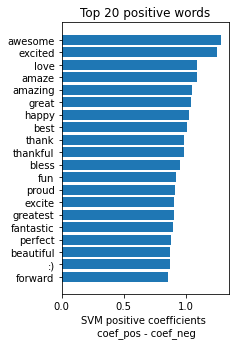

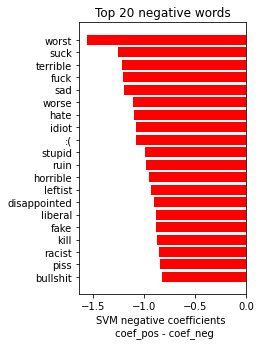

In [95]:
coefs = []
for i,id in enumerate(ID_train_dev):
    word = num2vocab[i+1]
    word_coef = (word, clf.coef_[2,i+1] - clf.coef_[0,i+1])
    coefs.append(word_coef)


coefs = sorted(coefs, key=lambda data: data[1], reverse=True)
coefs_topPositive = coefs[0:20]
coefs_topNegative = coefs[-20:]

# print("positive top 20:")
# print(coefs_topPositive)
# print("negative top 20:")
# print(coefs_topNegative)

import matplotlib.pyplot as plt
plt.figure(figsize =(3, 5))
names = [it[0] for it in coefs_topPositive]
names.reverse()
vals = [it[1] for it in coefs_topPositive]
vals.reverse()
plt.barh(names, vals)
plt.xlabel("SVM positive coefficients \n coef_pos - coef_neg"); plt.title("Top 20 positive words"); plt.show()

plt.figure(figsize =(3, 5))
names = [it[0] for it in coefs_topNegative]
vals = [it[1] for it in coefs_topNegative]
plt.barh(names, vals, color = 'red')
plt.xlabel("SVM negative coefficients \n coef_pos - coef_neg"); plt.title("Top 20 negative words"); plt.show()

In [60]:

clf.coef_[:,0]


array([0., 0., 0.])

### Logistic Regression (MaxEnt) Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

params = {'C':[  0.07, 0.1, 0.15, 0.2],
          'class_weight':['balanced'],
          'tol': [0.001],
          'max_iter': [500]
          }

grid_clf = GridSearchCV(
    estimator = LogisticRegression(),
    scoring = 'f1_macro',
    cv = 3,
    param_grid = params)

grid_clf.fit(Xtrain, Ytrain_numeric)
print('Best params: ', grid_clf.best_params_)
print(grid_clf.best_estimator_)
print(classification_report(y_test1_numeric, grid_clf.predict(sparse_test1)))
scores = abs(grid_clf.cv_results_['mean_test_score'])

# best params -> {'C': 0.15, 'class_weight': 'balanced', 'max_iter': 500, 'tol': 0.001}

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import time

Xtrain = sparse_train_dev  # combining the two datasets
print("shape", Xtrain.shape)###
ID_train = list(text_train.keys())            # list of IDs in train set
ID_dev = list(text_dev.keys())
ID_train_dev = ID_train + ID_dev
sn_train = [sent_train[id] for id in ID_train]  # training labels train
sn_dev = [sent_dev[id] for id in ID_dev]        # training labels dev
Ytrain = np.array(sn_train)            # combining both labels
Ytrain = np.array(sn_train + sn_dev)###            # combining both labels
Ytrain_numeric = np.array([sent2num(y) for y in Ytrain])   # numerical labels


t0 = time.time() # timing the run
#clf = LogisticRegression(C=0.15, tol=0.001, penalty='l2', class_weight='balanced', max_iter=1000, multi_class='multinomial')
clf = LogisticRegression(C=0.15, tol=0.001, class_weight='balanced', max_iter=1000, multi_class='multinomial')
clf.fit(Xtrain,Ytrain_numeric)

# evaluation test1
ID_test1 = list(text_test1.keys())
y_test1_numeric = np.array([sent2num(sent) for sent in sent_test1.values()])
y_pred_numeric = clf.predict(sparse_test1)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test1, y_pred))
s1 = evaluate(pred_dict, '../semeval-tweets/twitter-test1.txt', classifier="KNN")  # best score 0.562

# evaluation test2
ID_test2 = list(text_test2.keys())
y_test2_numeric = np.array([sent2num(sent) for sent in sent_test2.values()])
y_pred_numeric = clf.predict(sparse_test2)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test2, y_pred))
s2 = evaluate(pred_dict, '../semeval-tweets/twitter-test2.txt', classifier="KNN")  # best score 0.597

# evaluation test3
ID_test3 = list(text_test3.keys())
y_test3_numeric = np.array([sent2num(sent) for sent in sent_test3.values()])
y_pred_numeric = clf.predict(sparse_test3)
y_pred = [num2sent(num) for num in y_pred_numeric]
pred_dict = dict(zip(ID_test3, y_pred))
s3 = evaluate(pred_dict, '../semeval-tweets/twitter-test3.txt', classifier="KNN")  # best score 0.556
t1 = time.time()  # timing the run

print('overall run time:', t1-t0)
print("average F1 score:", (s1 + s2 + s3)/3)

shape (47101, 59467)
../semeval-tweets/twitter-test1.txt (KNN): 0.619
../semeval-tweets/twitter-test2.txt (KNN): 0.624
../semeval-tweets/twitter-test3.txt (KNN): 0.563
overall run time: 5.53150200843811
average F1 score: 0.6020903614585245


---
## Comparison of all classifiers

In [ ]:
# Buid traditional sentiment classifiers. An example classifier name 'svm' is given
# in the code below. You should replace the other two classifier names
# with your own choices. For features used for classifier training, 
# the 'bow' feature is given in the code. But you could also explore the 
# use of other features.
for classifier in ['NearestNeighbour', 'NaiveBayes','SVM']:
    for features in ['BOW', '<feature-2-name>']:
        # Skeleton: Creation and training of the classifiers
        if classifier == 'NearestNeighbour':
            # write the svm classifier here
            print('Training ' + classifier)
        elif classifier == 'NaiveBayes':
            # write the classifier 2 here
            print('Training ' + classifier)
        elif classifier == 'SVM':
            # write the classifier 3 here
            print('Training ' + classifier)
        elif classifier == 'LSTM':
            # write the LSTM classifier here
            if features == 'bow':
                continue
            print('Training ' + classifier)
        else:
            print('Unknown classifier name' + classifier)
            continue

        # Predition performance of the classifiers
        for testset in testsets:
            id_preds = {}
            # write the prediction and evaluation code here

            testset_name = testset
            testset_path = join('semeval-tweets', testset_name)
            evaluate(id_preds, testset_path, features + '-' + classifier)